In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import os

Using data from nevena flat line removal

In [37]:

# --- Data Loading ---
directory_path = r'/Users/rprocious/Waterlevels_CBI/CBI-2/nesscan_fixed_removed_flat_lines_03312025/bobHallPier'
dataframes = []
for filename in sorted(os.listdir(directory_path)):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(
            file_path,
            parse_dates=[0],
            na_values=[-999, -99, 99, 'NA', 'RM'],
            engine='python'
        )
        df.columns = ['date', 'pwl']
        dataframes.append(df)

bhp = pd.concat(dataframes, ignore_index=True)
bhp['date'] = pd.to_datetime(bhp['date'])
bhp = bhp[bhp['date'] >= pd.to_datetime('1996-01-01')]
bhp = bhp.reset_index(drop=True)

median_val = bhp['pwl'].median()
bhp.loc[np.abs(bhp['pwl'] - median_val) > 4, 'pwl'] = np.nan

n = len(bhp)
pwl = bhp['pwl'].values
third_diff = np.full(n, np.nan)

#pass one
for i in range(3, n):
    window = pwl[i-3:i+1]
    if np.isnan(window).any():
        continue
    third_val = window[0] - 3 * window[1] + 3 * window[2] - window[3]
    third_diff[i] = round(third_val, 5)

#+- 6 std removed
clean_vals = third_diff[~np.isnan(third_diff)]
mean_val = clean_vals.mean()
std_val = clean_vals.std()
threshold_upper = mean_val + 6 * std_val
threshold_lower = mean_val - 6 * std_val

#flagging repeated and spike
spike_flag = np.zeros(n, dtype=int)
pwl_cleaned = pwl.copy()

i = 3
while i < n:
    if np.isnan(pwl[i-3:i+1]).any():
        i += 1
        continue

    third_val = pwl[i-3] - 3 * pwl[i-2] + 3 * pwl[i-1] - pwl[i]

    if third_val > threshold_upper or third_val < threshold_lower:
        # Flag spike
        spike_flag[i] = 1
        spike_val = pwl[i]
        pwl_cleaned[i] = np.nan

        # Check for repeated values (exact matches) right after the spike
        j = 1
        while i + j < n and pwl[i + j] == spike_val:
            spike_flag[i + j] = 1
            pwl_cleaned[i + j] = np.nan
            j += 1

        i += j  # jump past the last repeated value
    else:
        i += 1

# --- Save Results ---
bhp['third_diff'] = third_diff
bhp['spike_flag'] = spike_flag
bhp['pwl_cleaned'] = pwl_cleaned

print(bhp.head(20))


                  date    pwl  third_diff  spike_flag  pwl_cleaned
0  1996-01-01 00:00:00  6.800         NaN           0        6.800
1  1996-01-01 00:06:00  6.773         NaN           0        6.773
2  1996-01-01 00:12:00  6.806         NaN           0        6.806
3  1996-01-01 00:18:00  6.833       0.066           0        6.833
4  1996-01-01 00:24:00  6.869      -0.015           0        6.869
5  1996-01-01 00:30:00  6.818       0.096           0        6.818
6  1996-01-01 00:36:00  6.823      -0.143           0        6.823
7  1996-01-01 00:42:00  6.834       0.050           0        6.834
8  1996-01-01 00:48:00  6.840       0.011           0        6.840
9  1996-01-01 00:54:00  6.855      -0.014           0        6.855
10 1996-01-01 01:00:00  6.823       0.056           0        6.823
11 1996-01-01 01:06:00  6.840      -0.096           0        6.840
12 1996-01-01 01:12:00  6.859       0.047           0        6.859
13 1996-01-01 01:18:00  6.827       0.053           0        6

Had to change from 5 repeated values after a spike to unlimited values after a spike due to this case of 2.777 6 times

In [39]:
bhp[576620:576670]

,date,pwl,third_diff,spike_flag,pwl_cleaned
576620,2002-07-30 14:00:00,6.658,0.002,0,6.658
576621,2002-07-30 14:06:00,6.627,0.020,0,6.627
576622,2002-07-30 14:12:00,6.629,-0.059,0,6.629
576623,2002-07-30 14:18:00,6.633,0.031,0,6.633
576624,2002-07-30 14:24:00,6.624,0.015,0,6.624
576625,2002-07-30 14:30:00,6.623,-0.021,0,6.623
576626,2002-07-30 14:36:00,6.618,0.012,0,6.618
576627,2002-07-30 14:42:00,6.629,-0.020,0,6.629
576628,2002-07-30 14:48:00,6.636,0.020,0,6.636
576629,2002-07-30 14:54:00,6.615,0.024,0,6.615


Text(0, 0.5, 'Freq')

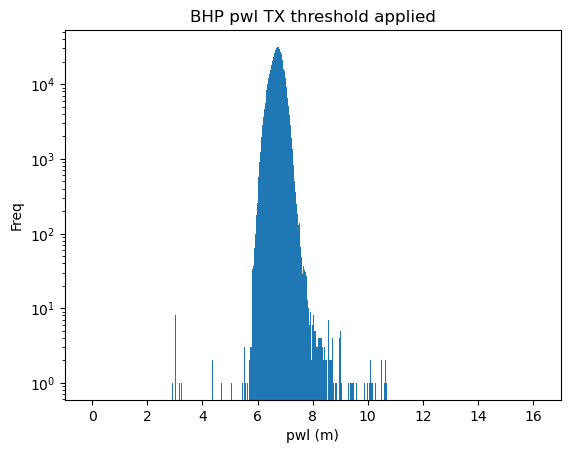

In [47]:
plt.hist(bhp['pwl'],1000)
plt.yscale('log')
plt.xlim(-1,17)
plt.title('BHP pwl TX threshold applied')
plt.xlabel('pwl (m)')
plt.ylabel('Freq')

Text(0, 0.5, 'Freq')

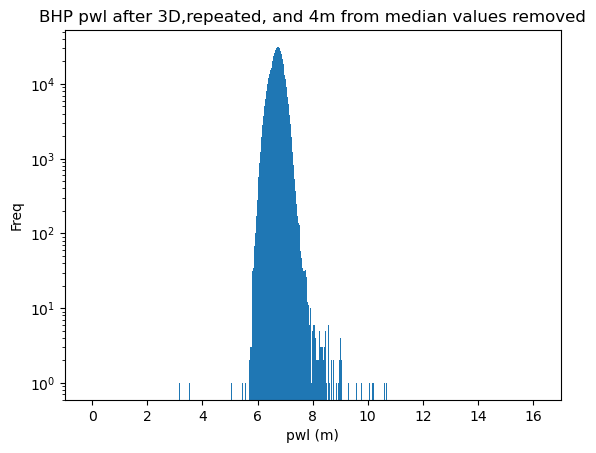

In [48]:
plt.hist(bhp['pwl_cleaned'],1000)
plt.yscale('log')
plt.xlim(-1,17)
plt.title('BHP pwl after 3D,repeated, and 4m from median values removed')
plt.xlabel('pwl (m)')
plt.ylabel('Freq')

In [49]:
bhp['pwl_cleaned'].idxmax()

576643

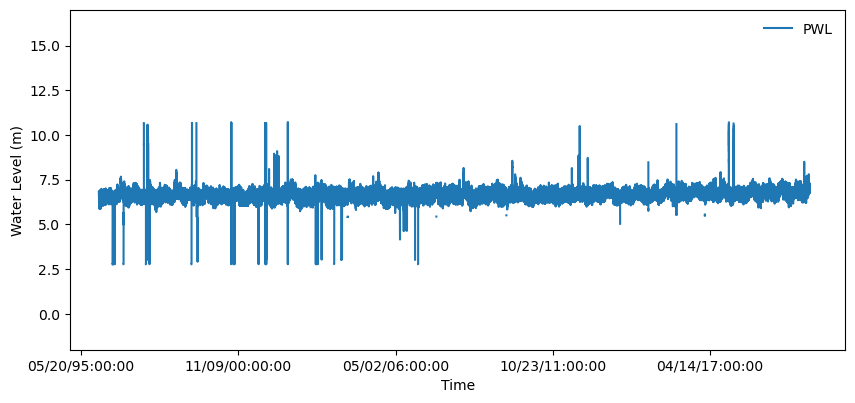

In [51]:
start_date = pd.to_datetime('1995/01/01 00:00')
end_date = pd.to_datetime('2021/12/30 03:30')

# Filter the data to only include the xlim range
filtered_data = bhp[(bhp['date'] >= start_date) & (bhp['date'] <= end_date)]

# Plot the filtered data
plt.figure(figsize=(10,5))
plt.plot(filtered_data['date'], filtered_data['pwl'], label='PWL')


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D:%H:%M'))

# Set tick locator for hourly intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2000))
# Autofmt the x-axis labels
plt.gcf().autofmt_xdate()

plt.xticks(rotation=0)

for label in plt.gca().get_xticklabels():
    label.set_ha('center')  # Set horizontal alignment to center

# Adjust y-axis limits
plt.ylim(-2,17)

# Set x-axis limits
plt.xlim(start_date, end_date)

# Add legend and title
plt.legend(frameon=False)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')

# Display the plot
plt.show()

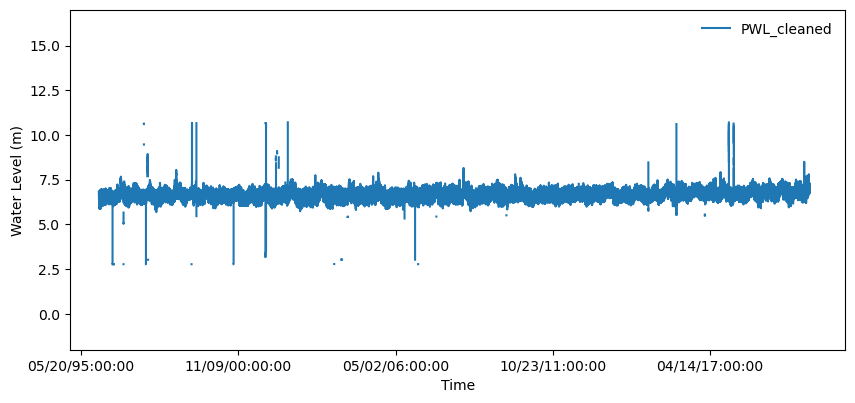

In [52]:
start_date = pd.to_datetime('1995/01/01 00:00')
end_date = pd.to_datetime('2021/12/30 03:30')

# Filter the data to only include the xlim range
filtered_data = bhp[(bhp['date'] >= start_date) & (bhp['date'] <= end_date)]

# Plot the filtered data
plt.figure(figsize=(10,5))
plt.plot(filtered_data['date'], filtered_data['pwl_cleaned'], label='PWL_cleaned')


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D:%H:%M'))

# Set tick locator for hourly intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2000))
# Autofmt the x-axis labels
plt.gcf().autofmt_xdate()

plt.xticks(rotation=0)

for label in plt.gca().get_xticklabels():
    label.set_ha('center')  # Set horizontal alignment to center

# Adjust y-axis limits
plt.ylim(-2,17)

# Set x-axis limits
plt.xlim(start_date, end_date)

# Add legend and title
plt.legend(frameon=False)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')

# Display the plot
plt.show()

Need to find a way to handle the values after a gap, maybe switching to a forward pass at those locations

In [46]:
bhp[41420:41450]

,date,pwl,third_diff,spike_flag,pwl_cleaned
41420,1996-06-21 14:00:00,NaN,NaN,0,NaN
41421,1996-06-21 14:06:00,NaN,NaN,0,NaN
41422,1996-06-21 14:12:00,NaN,NaN,0,NaN
41423,1996-06-21 14:18:00,NaN,NaN,0,NaN
41424,1996-06-21 14:24:00,NaN,NaN,0,NaN
41425,1996-06-21 14:30:00,NaN,NaN,0,NaN
41426,1996-06-21 14:36:00,NaN,NaN,0,NaN
41427,1996-06-21 14:42:00,NaN,NaN,0,NaN
41428,1996-06-21 14:48:00,NaN,NaN,0,NaN
41429,1996-06-21 14:54:00,NaN,NaN,0,NaN
